Author: Group E <br>
Date: 2021-03-08 <br>
Licence: MIT License <br>
Data: [Food Data Spain](https://drive.google.com/file/d/1RezG_tzb2XMshS7mm1QY8hAhZW1u6F-6/view) <br>
Healthy Labels: [Food Labels](https://www.nhs.uk/live-well/eat-well/how-to-read-food-labels/?tabname=digestive-health)

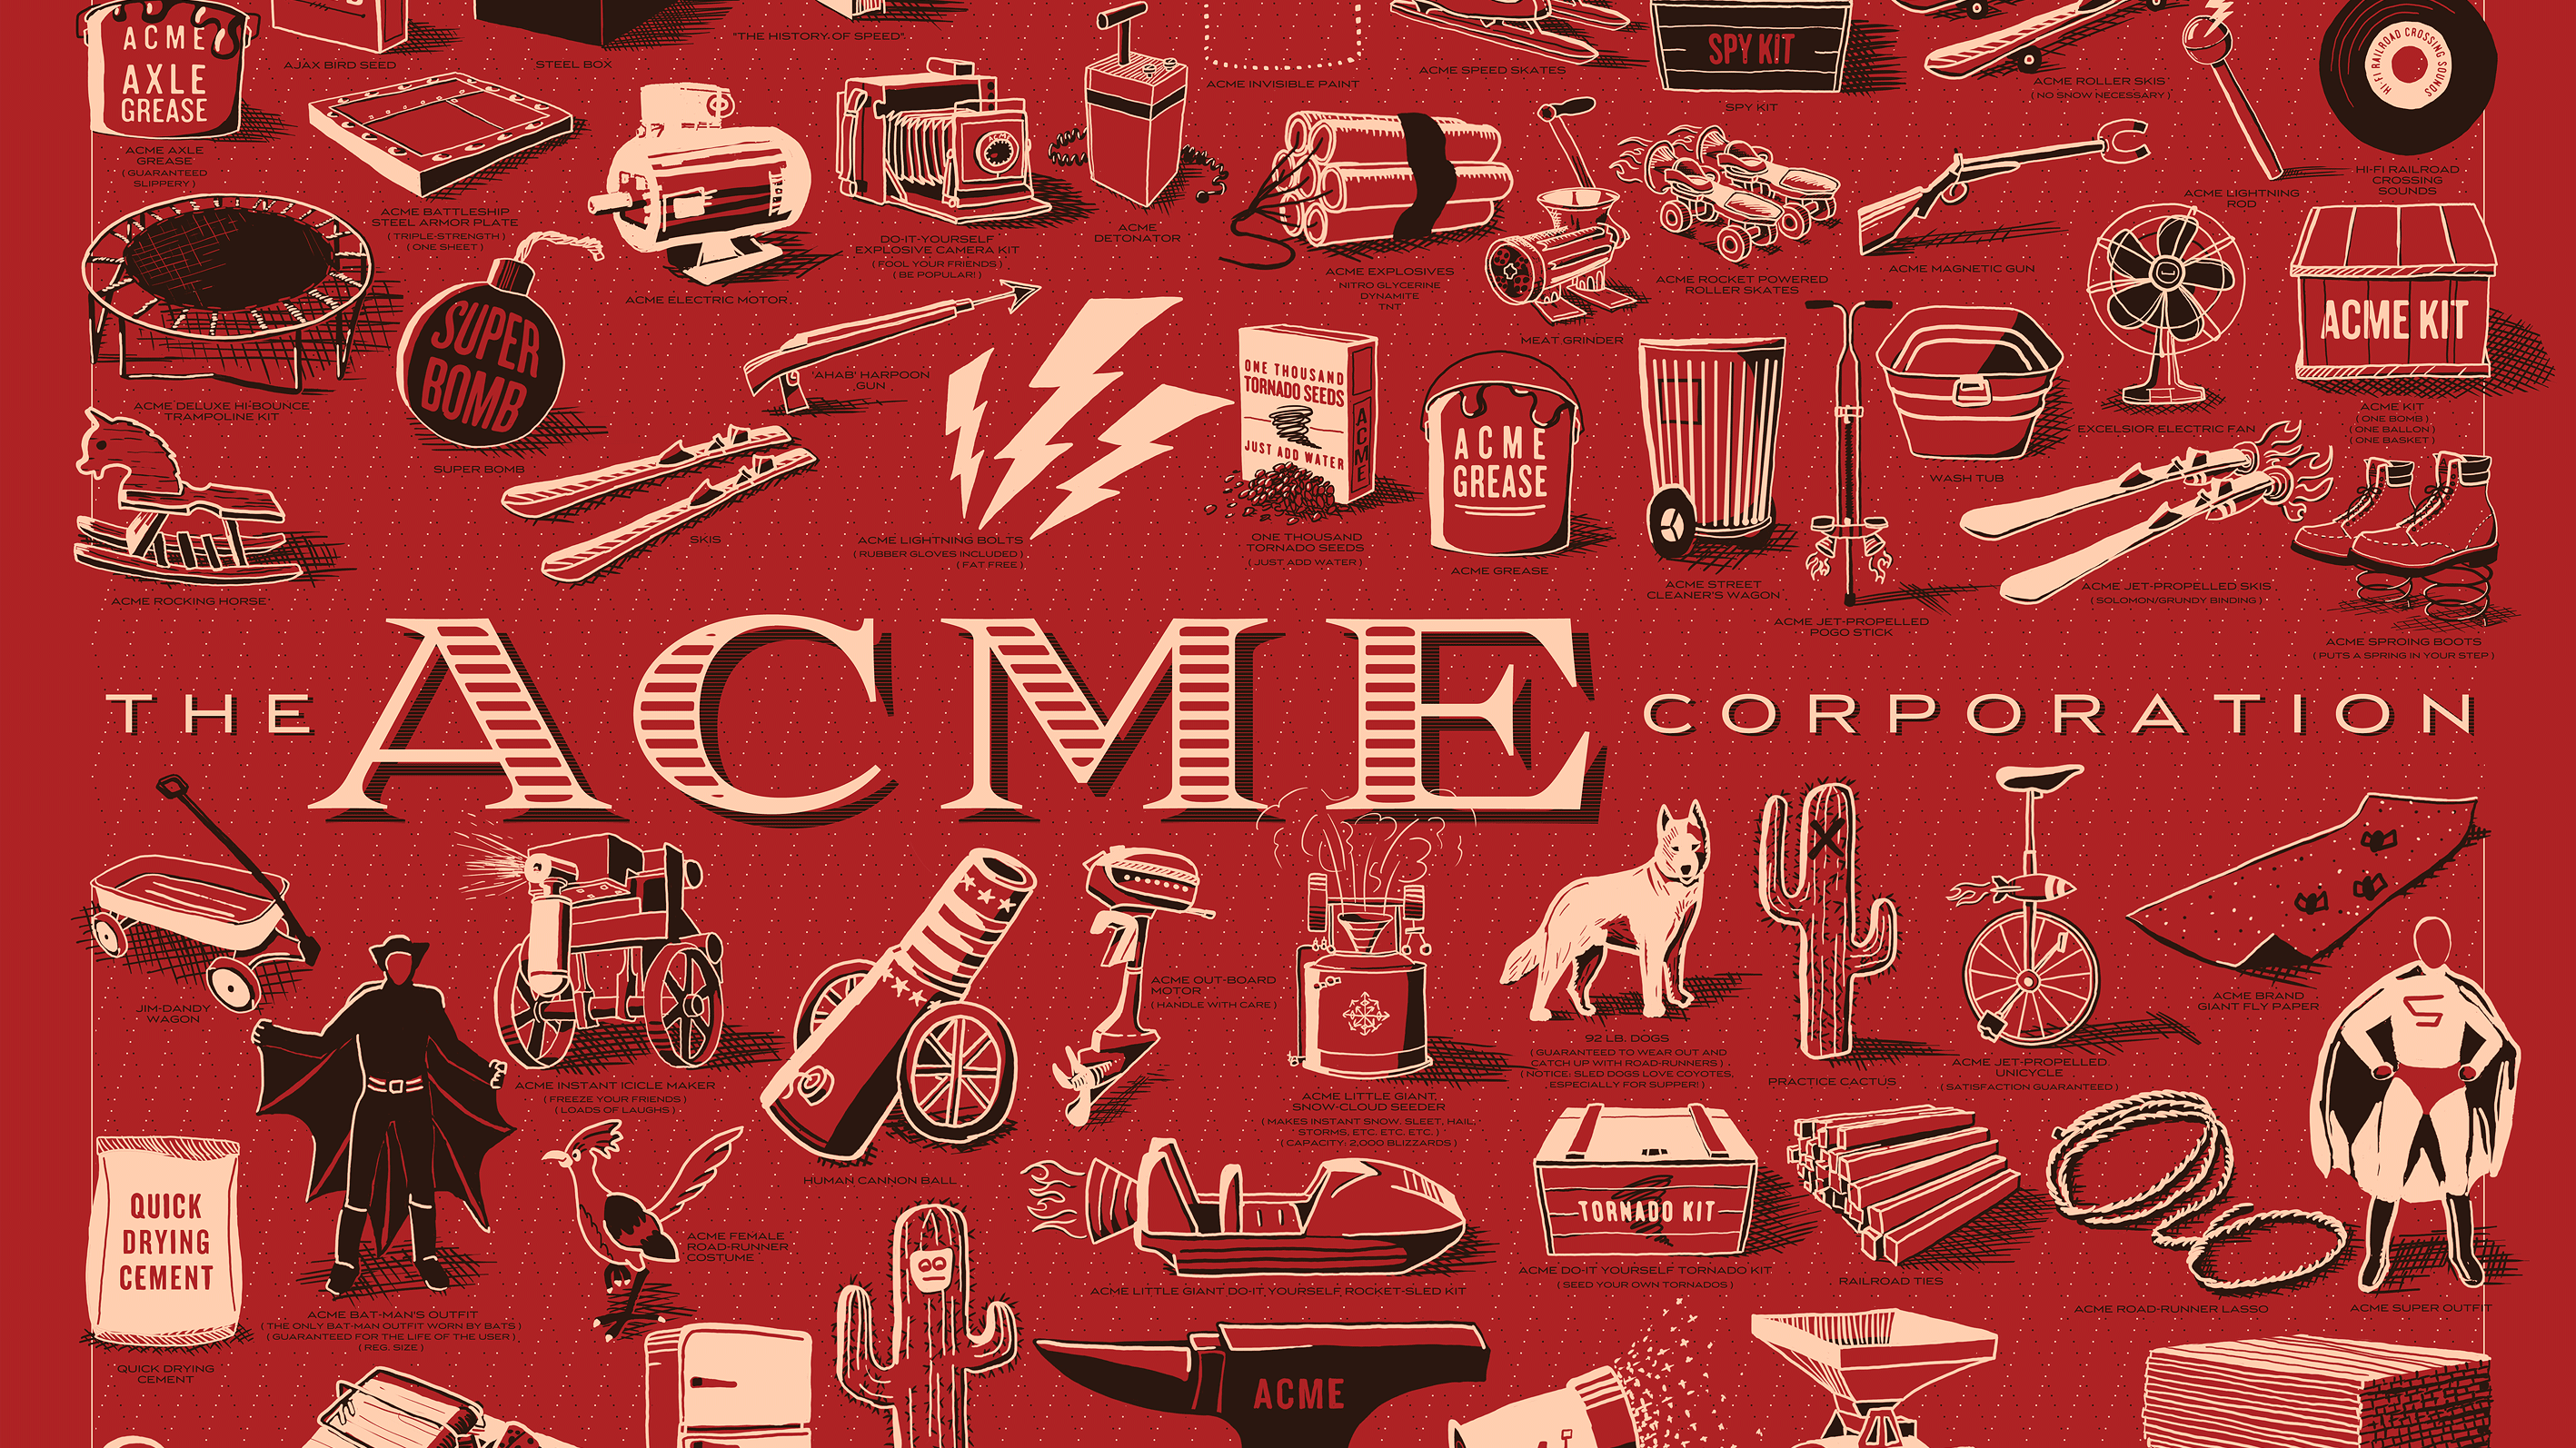

ACME corporation is trying to understand eating habits in Spain and, given that they don’t have any team able to do data analysis, they are asking for help. This report investigates that and analyses the Spanish data set in order to finally be able to assist ACME in strategizing their entry to the Spanish health industry. This is done by determining  determine how healthy the different products are (based on NHS data) and how a simple product feature to enter this market could look like. 

**Table of Contents:**  

1. Assumptions & Limitations
2. PySpark Environment Setup
3. Dataframe Setup 
4. Metadata Analysis
5. Preliminary Data Analysis
6. Product Information
7. Traces Analysis
8. Data Analysis 
9. Data Profiling
10. Product Health Information

# 1. Assumptions & Limitations
### 1.1 Assumptions
1. [NHS data on health representative for a daily healthy intake](https://www.nhs.uk/live-well/eat-well/how-to-read-food-labels/?tabname=digestive-health)
2. Food is representative for a healthy life
3. Spain is health oriented → good market (mediterranian diet) 
4. Health education in Europe still in the making: Spain = good starting point

### 1.2 Limitations
1. Relatively small data set with a lot of null values
2. Uncomplete or rather messy data set
3. Focus on small fraction of attributes for the goal of this analysis:'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g'


# 2. PySpark Environment Setup
Importing the relevant libraries and creating the Spark instance before we start our analysis

In [1]:
# Importing pyspark library
import findspark
findspark.init()

In [2]:
# Importing relevant libraries
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# 3. Dataframe Setup
We are importing the data set with header and delimeter options

In [3]:
# Setting up the data frame
df = (
    spark
      .read
      .option("inferSchema", "true")
      .option("header", "true")
      .option("sep", "\t") # tab delimiter
      .csv("en.openfoodfacts.org.products.Spain.with_headers.csv")
      .cache()
     )

In [4]:
# Understanding the different variables present in the data frame
df.columns

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'packaging_text',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'origins_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_t

# 4. Metadata Analysis
We are going to anaylse and differentiate columns in this section
### 4.1 Display schema and size of the DataFrame

In [5]:
# Downloading relevant libraries
from IPython.display import display, Markdown
from pyspark.sql.types import *

In [6]:
# Checking the schema of the data frame
df.printSchema()
"This DataFrame has {} rows and {} columns.".format(df.count(), len(df.columns)) 

root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- origins_en: string (nullable = true)
 |-- manufacturing_places: str

'This DataFrame has 204318 rows and 184 columns.'

### 4.2 Get one sample from the data set

In [7]:
# take(1)
display(df.take(1))

[Row(code=3327986.0, url='http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado', creator='kiliweb', created_t=1574175736, created_datetime=datetime.datetime(2019, 11, 19, 16, 2, 16), last_modified_t=1574175737, last_modified_datetime=datetime.datetime(2019, 11, 19, 16, 2, 17), product_name='Filetes de pollo empanado', abbreviated_product_name=None, generic_name=None, quantity=None, packaging=None, packaging_tags=None, packaging_text=None, brands=None, brands_tags=None, categories=None, categories_tags=None, categories_en=None, origins=None, origins_tags=None, origins_en=None, manufacturing_places=None, manufacturing_places_tags=None, labels=None, labels_tags=None, labels_en=None, emb_codes=None, emb_codes_tags=None, first_packaging_code_geo=None, cities=None, cities_tags=None, purchase_places=None, stores=None, countries='en:es', countries_tags='en:spain', countries_en='Spain', ingredients_text=None, allergens=None, allergens_en=None, traces=None, trac

### 4.3 Data entities, metrics and dimensions

The following elements were identified:

* **Entities:** Product
* **Metrics:** energy-kcal_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, proteins_100g, salt_100g and many more columns with information regarding 100g content
* **Dimensions:** created_t, created_datetime, last_modified_t, last_modified_datetime, url

### 4.4 Column categorization

The following could be a potential column categorization:

* **Issue related columns:** energy-kcal_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, proteins_100g, salt_100g

# 5. Preliminary Data Analysis

In [8]:
from IPython.display import display, Markdown

In [9]:
df.schema.names

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'packaging_text',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'origins_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_t

In [10]:
print ("Summary of columns:")
df.summary().toPandas()

Summary of columns:


,summary,code,url,creator,created_t,last_modified_t,product_name,abbreviated_product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,count,204318,204318,204318,204318,204318,191305,33,7952,39505,...,91,58197,0,0,0,1,2,4,0,0
1,mean,5.892257979892543E37,None,Infinity,1.5707586978829715E9,1.5933255177959993E9,NaN,None,None,154.98687173913046,...,456.4696043956043,8.86580064264481,None,None,None,0.108,0.0,3.3000000000000003,None,None
2,stddev,2.413229123228395E40,None,NaN,3.437635563593963E7,1.3498603629403153E7,NaN,None,None,210.1878695275914,...,709.0030874654744,8.670389042274422,None,None,None,NaN,0.0,2.04939015319192,None,None
3,min,1.0,http://world-en.openfoodfacts.org/product/0000...,99fran,1332257652,1415985139,#ke by kelia pipas,"Authentique 275g, fr",'tranches' de céréales avec 30% de crème de lait,&lt;318G 6 HUEVOS,...,1.47,-14,None,None,None,0.108,0.0,0.4,None,None
4,25%,5.600826205525E12,None,Infinity,1566726518,1580579633,280.0,None,None,3.0,...,74.0,1,None,None,None,0.108,0.0,0.4,None,None
5,50%,8.414543100295E12,None,Infinity,1573566440,1595179795,1900.0,None,None,60.0,...,305.5,8,None,None,None,0.108,0.0,3.6,None,None
6,75%,8.436042700011E12,None,Infinity,1584726291,1605812519,NaN,None,None,250.0,...,606.8,15,None,None,None,0.108,0.0,4.0,None,None
7,max,1.0843700286646415E43,http://world-en.openfoodfacts.org/product/9999...,zqott,1614042332,1614043610,饮用天然水,Piccolinis tomate mozzarella 270g,☕️ espresso instant coffee,"२५०g,",...,4283.5,40,None,None,None,0.108,0.0,5.2,None,None


In [11]:
# Creating a list of all columns in the data frame 
analysis_col_list = df.schema.names

print("Checking for nulls on all columns:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in analysis_col_list]).toPandas()

Checking for nulls on all columns:


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0,0,0,0,0,0,0,13013,204285,196366,...,204227,146121,204318,204318,204318,204317,204316,204314,204318,204318


We have 13013 products without a registered name and more than 200_000 products are missing most of the analysis per 100g.

# 6. Product Information
In the product information section, this report will focus on the following two topics:
1. Product Statistics
2. Product Categories

### 6.1 Product Statistics
1. Oldest product
2. Newest product
3. Average product age
4. List of countries where products are sold to

#### 6.1.1 Oldest Product 

In [12]:
print("We are going to see the oldest product in the system")
oldest = (
    df
    .where(df["product_name"].isNotNull())
    .select("created_datetime", "product_name")
    .withColumnRenamed("created_datetime", "Creation Date")
    .withColumnRenamed("product_name", "Product")
    .sort(df["created_t"].asc())
    .show(1, False)
)


We are going to see the oldest product in the system
+-------------------+----------------------+
|Creation Date      |Product               |
+-------------------+----------------------+
|2012-03-20 16:34:12|Moutarde fine de Dijon|
+-------------------+----------------------+
only showing top 1 row



#### 6.1.2 Newest Product 

In [13]:
print("We are going to see the newest product in the system")
newest = (
    df
    .where(df["product_name"].isNotNull()) # remove products without names
    .select("created_datetime", "product_name")
    .withColumnRenamed("created_datetime", "Creation Date")
    .withColumnRenamed("product_name", "Product")
    .sort(df["created_t"].desc())
    .show(1, False)
)

We are going to see the newest product in the system
+-------------------+------------+
|Creation Date      |Product     |
+-------------------+------------+
|2021-02-23 01:25:24|Relaxing tea|
+-------------------+------------+
only showing top 1 row



There is a 9-year gap between the oldest and newest registered product.

#### 6.1.3 Average product age 
Age in this context means how long the product has been in the system

In [14]:
from datetime import datetime, timedelta
import time

# get today's timestamp
today = time.time()

In [15]:
# seconds until today
def calculate_age(x):
    return today - col(x)

intervals = (
    ('years', 31536000), # 60 * 60 * 24 * 365
    ('months', 2592000),  # 60 * 60 * 24 * 30
    ('weeks', 604800), # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
)

# turns seconds into years, months, days, hours, minutes, seconds
def display_time(seconds, granularity=2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

In [16]:
df2 = (
    df
    .withColumn("age", calculate_age("created_t")) # get another age column with from created_t
) #rename

# get the average timestamp value
ts = int(
    df2
    .agg({"age": "avg"})
    .toPandas()
    .iloc[0]['avg(age)']
)

# display the timestamp in years, months, weeks etc.
print("The average product age after being registered to the system:")
display_time(ts, 6)

The average product age after being registered to the system:


'1 year, 4 months, 2 weeks, 5 days, 13 hours, 1 minute'

Even though we have the oldest product registered in 2012, the average registration age is quite low. 

#### 6.1.4 List of other countries products sold to

In [17]:
# explode values of countries and collect them on a single data frame
countries = (
    df
    .select(explode(split(col("countries_en"), ',')).alias("Countries"))
    .distinct()
    .filter(col("countries_en") != 'Spain') # EXCLUDE SPAIN
    .toPandas()
) 

print("List of countries:")
countries

List of countries:


,Countries
0,Côte d'Ivoire
1,Luxemburgo
2,Middle-east-africa
3,es:espanha
4,Czech-republic-čeština
...,...
357,Mali
358,Netherlands
359,Slovak-republic-slovenčina
360,Suecia


There are some wrongly formatted country names in the "country_en" column such as "es:espanha". We would expect all columns to be in English.

### 6.2 Product Categories

Exclude null values and rename the main category column. Group by main category and add counts. Sort by category.

1. Number of products by category
2. List containing names of products by category

#### 6.2.1 Number of products by category

In [18]:
categories_count = (
    df
    .where(df["main_category_en"].isNotNull()) # eliminate null columns
    .withColumnRenamed("main_category_en", "Main Category")
    .groupBy("Main Category")
    .count()
    .withColumnRenamed("count", "Count")
    .distinct()
    .sort(desc("Count"))
    .toPandas()
)

print("Main categories list:")
categories_count

Main categories list:


,Main Category,Count
0,Cheeses,1219
1,Biscuits,1085
2,Extra-virgin olive oils,1084
3,Prepared meats,884
4,Serrano ham,740
...,...,...
3283,Canned paddy straw mushrooms,1
3284,fr:yaourt-riz-au-lait,1
3285,Mint teas,1
3286,Egg white powder,1


There are main categories written in different languages such as French represented as "fr:main_category" even though the column is called main_category_en.

#### 6.2.2 List containing names of products by category

In [19]:
categories_list = (
    df
    .where(df["product_name"].isNotNull()) # eliminate null columns
    .where(df["main_category_en"].isNotNull()) # eliminate null columns
    .select(lower(col("product_name")), lower(col("main_category_en")))
    .withColumnRenamed("lower(main_category_en)", "Main Category")
    .withColumnRenamed("lower(product_name)", "Product Name")
    .distinct()
    .sort(df["main_category_en"].asc())
)

print("Product names and their categories:")
categories_list.toPandas()

Product names and their categories:


,Product Name,Main Category
0,galego,11% white wine
1,curcuma rama,3
2,miel acacia,acacia honeys
3,miel de acacia con trozos de panal,acacia honeys
4,panal miel de acacia,acacia honeys
...,...,...
51236,boisson nutritionnelle,it:integratori
51237,konnyaku mai,it:konjac
51238,konjac linguine,it:konjac
51239,xtra-cal,pt:suplemento-alimentar


We had to lower the values in the product name column since the same products were repeated many times with differently capitalized names. 

# 7. Traces Analysis

Exclude null values and rename the main category column. Group by main category and add counts. Sort by category.

1. Number of products by trace
2. List containing names of products by trace

### 7.1 Number of products by trace

In [20]:
traces_list = (
    df
    .where(df["traces_en"].isNotNull()) # eliminate null columns
    .withColumnRenamed("traces_en", "Product Traces")
    .groupBy("Product Traces")
    .count()
    .withColumnRenamed("count", "Count")
    .distinct()
    .sort(desc("Count"))
    .toPandas()
)

print("Traces list:")
traces_list

Traces list:


,Product Traces,Count
0,Nuts,671
1,Milk,422
2,Soybeans,315
3,"Milk,Nuts",297
4,"Nuts,Peanuts",264
...,...,...
1231,"Gluten,Nuts,Soybeans,Sulphur dioxide and sulph...",1
1232,"Eggs,Gluten,Milk,Mustard,Nuts,Peanuts,Sesame s...",1
1233,"Fish,Molluscs,es:puede-contener-razas-de-pesca...",1
1234,"Gluten,Milk,Mustard,Nuts,Sesame seeds,Soybeans",1


### 7.2 List containing names of products by trace

In [21]:
traces_count = (
    df
    .where(df["product_name"].isNotNull()) # eliminate null columns
    .where(df["traces_en"].isNotNull()) # eliminate null columns
    .select(lower(col("traces_en")), lower(col("product_name")))
    .withColumnRenamed("lower(traces_en)", "Product Traces")
    .withColumnRenamed("lower(product_name)", "Product Name")
    .distinct()
    .sort(df["traces_en"].asc())
)

print("Product and trace list:")
traces_count.toPandas()

Product and trace list:


,Product Traces,Product Name
0,"almendra,avellana,nuez-pecan,pistacho",ser chocolate
1,balanced-diet-and-a-healthy-lifestyle-is-recom...,oat unsweetened milk
2,caffeina,infuso erbe al limone gr 50
3,"cebada,contiene-derivados-de-soja-puede-conten...",caldo de verduras
4,celery,crema pollo con verduras
...,...,...
6983,pt:isento-de-gluten,tortitas maíz
6984,pt:pode-conter-leite,nestum zero. espelta y avena
6985,pt:um-consumo-excessivo-pode-ter-fator-relaxam...,frusitos
6986,ro:apa,"borsec, regina apelor minerale apă minerală, n..."


# 8. Data Analysis
Data quality analysis on fields of interest:
1. Number of products with complete information
2. Percentage of products without complete analysis per 100g
3. Percentage of products without additives information
4. Percentage of products without traces info

In [22]:
# our issue related fields of interest
fields_of_interest = [
    'energy-kcal_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'carbohydrates_100g',
    'sugars_100g',
    'proteins_100g', 
    'salt_100g'
]

In [23]:
# columns with complete info
complete_info = (
    df
    .select(fields_of_interest)
    .na
    .drop()
    .toPandas()
)

### 8.1 Number of products with complete info

In [24]:
# get the total number products with complete info with fields of interest
complete_info_count = complete_info.count()

print("Number of products with complete info:")
complete_info_count[0]

Number of products with complete info:


149625

### 8.2 Percentage of products without complete analysis per 100g

In [25]:
# get the total count
total_count = df.count()

In [26]:
# percentage of products without complete analysis

print("Percentage of products without complete analysis per 100g:")
100 - complete_info_count[0] / total_count * 100

Percentage of products without complete analysis per 100g:


26.76856664611047

### 8.3 Percentage of products without additives information

In [27]:
total_count = df.count()
additive_null = df.filter(df["additives_en"].isNull()).count()

print("Percentage of products without additive information:")
print(additive_null / total_count * 100)

Percentage of products without additive information:
94.61574604293308


### 8.4 Percentage of products without traces info

In [28]:
traces_null = df.filter(df["traces_en"].isNull()).count()

print("Percentage of products without traces info:")
print(traces_null / total_count * 100)

Percentage of products without traces info:
96.34099785628285


# 9. Data Profiling
Data profiling on fields of interest for the final product health information analysis:
1. NHS Product Health Information
2. Profiling for columns of interest, according to NHS
3. Stats on analysis per 100g field

##### COLUMNS OF INTEREST IN THE END
[
    'fat_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'salt_100g'
]

### 9.1 NHS Product Health Information
**Total fat** 
- High: more than **17.5g** of fat per 100g <br>
- Low: **3g** of fat or less per 100g <br>

**Saturated fat** 
- High: more than **5g** of saturated fat per 100g <br>
- Low: **1.5g** of saturated fat or less per 100g  <br>

**Sugars**
- High: more than **22.5g** of total sugars per 100g <br>
- Low: **5g** of total sugars or less per 100g <br>

**Salt**
- High in salt: more than **1.5g** of salt per 100g <br>
- Low in salt: **0.3g** of salt or less per 100g <br>



### 9.2 Profiling for columns of interest, according to NHS

In [29]:
interestColumnsDF = (
    df
    .where(col("fat_100g").isNotNull())
    .where(col("saturated-fat_100g").isNotNull())
    .where(col("sugars_100g").isNotNull())
    .where(col("salt_100g").isNotNull())
    .withColumn("total_fat_level_100g", 
                when(col("fat_100g")<=3, "1. low")
                .when((col("fat_100g")>3) & (col("fat_100g")<=17.5), "2. normal")
                .otherwise("3. high")
               )
    .withColumn("saturated_fat_level_100g", 
                when(col("saturated-fat_100g")<=1.5, "1. low")
                .when((col("saturated-fat_100g")>1.5) & (col("saturated-fat_100g")<=5.0), "2. normal")
                .otherwise("3. high")
               )
    .withColumn("salt_level_100g", 
                when(col("salt_100g")<=0.3, "1. low")
                .when((col("salt_100g")>0.3) & (col("salt_100g")<=1.5), "2. normal")
                .otherwise("3. high")
               )
    .withColumn("sugar_level_100g", 
                when(col("sugars_100g")<=5, "1. low")
                .when((col("sugars_100g")>5) & (col("sugars_100g")<=22.5), "2. normal")
                .otherwise("3. high")
               )
    .cache() # optimization to make the processing faster
)

In [30]:
print("Listing the newly created columns:")
interestColumnsDF.select("product_name", "total_fat_level_100g", "saturated_fat_level_100g", "sugar_level_100g", "salt_level_100g").toPandas()

Listing the newly created columns:


,product_name,total_fat_level_100g,saturated_fat_level_100g,sugar_level_100g,salt_level_100g
0,Iogurt de cabra,2. normal,2. normal,1. low,1. low
1,Tarta San Marcos,2. normal,3. high,3. high,1. low
2,Tarta fresa,2. normal,3. high,3. high,1. low
3,Lote jamón gran reserva navidul,3. high,3. high,1. low,3. high
4,Bratwurst moving mountains,2. normal,3. high,1. low,2. normal
...,...,...,...,...,...
151957,Chorizo,3. high,3. high,1. low,3. high
151958,Lonchera de paleta de cebo iberica 50% raza Ib...,3. high,3. high,1. low,3. high
151959,Jamón de Jabugo,3. high,3. high,1. low,3. high
151960,Loncheado de paleta de cebo de campo 100% iberico,3. high,3. high,1. low,3. high


# 10 Product Health Information
1. Product health statistics
2. Number of products that are healthy (absolute & percentage)
3. Healthy basket example (3 if possible)

### 10.1 Product health statistics

#### 10.1.1 Total fat level per 100g

In [31]:
# total count with not null values of our interest columns
total_count_interest = interestColumnsDF.na.drop(subset=["total_fat_level_100g", "saturated_fat_level_100g", "sugar_level_100g", "salt_level_100g"]).count()

In [32]:
print("The distribution of products according to total fat level in 100g:")
interestColumnsDF.select("total_fat_level_100g")\
                     .groupBy("total_fat_level_100g")\
                     .agg(count("total_fat_level_100g").alias("num_products"), \
                          (count("total_fat_level_100g")/total_count_interest*100).alias("total_fat_level_ratio"))\
                     .orderBy("total_fat_level_100g")\
                     .select("total_fat_level_100g", "num_products" , round("total_fat_level_ratio", 2).alias("total_fat_level_ratio(%)")).show()

The distribution of products according to total fat level in 100g:
+--------------------+------------+------------------------+
|total_fat_level_100g|num_products|total_fat_level_ratio(%)|
+--------------------+------------+------------------------+
|              1. low|       52472|                   34.53|
|           2. normal|       47843|                   31.48|
|             3. high|       51647|                   33.99|
+--------------------+------------+------------------------+



There is a homogenous distribution for total fat per 100g for registered products.

#### 10.1.2 Saturated fat level per 100g

In [33]:
print("The distribution of products according to saturated fat level in 100g:")
interestColumnsDF.select("saturated_fat_level_100g")\
                     .groupBy("saturated_fat_level_100g")\
                     .agg(count("saturated_fat_level_100g").alias("num_products"), \
                          (count("saturated_fat_level_100g")/total_count_interest*100).alias("saturated_fat_level_ratio"))\
                     .orderBy("saturated_fat_level_100g")\
                     .select("saturated_fat_level_100g", "num_products" , round("saturated_fat_level_ratio", 2).alias("saturated_fat_level_ratio(%)")).show()

The distribution of products according to saturated fat level in 100g:
+------------------------+------------+----------------------------+
|saturated_fat_level_100g|num_products|saturated_fat_level_ratio(%)|
+------------------------+------------+----------------------------+
|                  1. low|       68260|                       44.92|
|               2. normal|       35672|                       23.47|
|                 3. high|       48030|                       31.61|
+------------------------+------------+----------------------------+



Ratio of normal saturated fat level for 100g products are relatively low compared to low and high levels.

#### 10.1.3 Sugar level per 100g

In [34]:
print("The distribution of products according to saturated fat level in 100g:")
interestColumnsDF.select("sugar_level_100g")\
                     .groupBy("sugar_level_100g")\
                     .agg(count("sugar_level_100g").alias("num_products"), \
                          (count("sugar_level_100g")/total_count_interest*100).alias("sugar_level_ratio"))\
                     .orderBy("sugar_level_100g")\
                     .select("sugar_level_100g", "num_products" , round("sugar_level_ratio", 2).alias("sugar_level_ratio(%)")).show()

The distribution of products according to saturated fat level in 100g:
+----------------+------------+--------------------+
|sugar_level_100g|num_products|sugar_level_ratio(%)|
+----------------+------------+--------------------+
|          1. low|      103007|               67.78|
|       2. normal|       25137|               16.54|
|         3. high|       23818|               15.67|
+----------------+------------+--------------------+



Most of the registered products have low level of sugar.

#### 10.1.4 Salt level per 100g

In [35]:
print("The distribution of products according to salt level in 100g:")
interestColumnsDF.select("salt_level_100g")\
                     .groupBy("salt_level_100g")\
                     .agg(count("salt_level_100g").alias("num_products"), \
                          (count("salt_level_100g")/total_count_interest*100).alias("salt_level_ratio"))\
                     .orderBy("salt_level_100g")\
                     .select("salt_level_100g", "num_products" , round("salt_level_ratio", 2).alias("salt_level_ratio(%)")).show()

The distribution of products according to salt level in 100g:
+---------------+------------+-------------------+
|salt_level_100g|num_products|salt_level_ratio(%)|
+---------------+------------+-------------------+
|         1. low|       60712|              39.95|
|      2. normal|       52785|              34.74|
|        3. high|       38465|              25.31|
+---------------+------------+-------------------+



Salt level is mostly low or normal in registered products.

### 10.2 Number of products that are healthy

In [40]:
healthy_products = (
    in
    terestColumnsDF
    .filter(interestColumnsDF["salt_level_100g"] == "2. normal")
    .filter(interestColumnsDF["saturated_fat_level_100g"] == "2. normal")
    .filter(interestColumnsDF["sugar_level_100g"] == "2. normal")
    .filter(interestColumnsDF["salt_level_100g"] == "2. normal")
)

print("Number of products that satisfy normal levels defined for a healthy product:")
healthy_products.count()

Number of products that satisfy normal levels defined for a healthy product:


2179

There are just 2179 registered products that satisfy the normal intervals for all four ingredients.

### 10.3 A healthy basket example

In [49]:
print("10 products that have healthy levels of sugar, total fat, saturated fat and salt for our basket:")
(
    healthy_products
    .where(df["product_name"].isNotNull())
    .select('product_name')
    .take(10)
)

10 products that have healthy levels of sugar, total fat, saturated fat and salt for our basket:


[Row(product_name='Pure whey protein'),
 Row(product_name='Proteina whey sabor chocolate blanco'),
 Row(product_name='Love crunch dark chocolate and red berries'),
 Row(product_name='Jamón de gigante'),
 Row(product_name='Choco krispies Whitea'),
 Row(product_name='Wasabi Peas'),
 Row(product_name='Hawaiian sweet rolls'),
 Row(product_name='Neapolitan'),
 Row(product_name='Caramel Corn'),
 Row(product_name='Ancient grains granola with almonds')]